# open, examine, and plot some variables from the zarr output 

- Relevant information summarized on the [PINACES RCE website](https://portal.nersc.gov/cfs/m1867/pinacles_docs/site/fields_zarr/)

In [1]:
import zarr
import numpy as np

import json
import matplotlib.pyplot as plt

import xarray as xr

sys.path.append("/global/common/software/m1867/python/ksa_env")
from ks_pkg import ksa_functions as ksf #use RMSE, etc



loading ks_pkg module in /global/common/software/m1867/python/ksa_env/ks_pkg ks_pkg
KS package:  scipy version: 1.11.1


In [34]:
def find_closest_index(array, target):
    """Finds the index of the closest value to target in array."""
    # Ensure the array is sorted
    array = np.sort(array)

    # Calculate the absolute differences
    diffs = np.abs(array - target)

    # Find the index of the minimum difference
    return np.argmin(diffs)

In [107]:
def int2npdt64(iyear=np.nan,imonth=np.nan,iday=np.nan,ihour=np.nan,imin=np.nan,isec=np.nan,iunits='NAT'):
    nptime = np.datetime64('NAT')  #Not A Time value as default
        
    if(np.isnan(iyear)):
        raise ValueError('int2npdt64: iyear should have a valid number as string')
    else:
        timestr = str(iyear).zfill(4)
        if(np.isnan(imonth)):
            raise ValueError('int2npdt64: imonth should have a valid number as string')
        else:
            timestr = (timestr + '-' + str(imonth).zfill(2))
            if(np.isnan(iday)):
                print('int2npdt64: iday not provided')
            else:
                timestr = (timestr + '-' + str(iday).zfill(2))
            if(np.isnan(ihour)):
                print('int2npdt64: ihour not provided')
            else:
                timestr = (timestr + 'T' + str(ihour).zfill(2))
            if(np.isnan(imin)):
                print('int2npdt64: imin not provided')
            else:
                timestr = (timestr + ':' + str(imin).zfill(2))
            if(np.isnan(isec)):
                print('int2npdt64: isec not provided')
            else:
                timestr = (timestr + ':' + str(isec).zfill(2))
        
    if(iunits != 'NAT'):
        nptime = np.datetime64(timestr,iunits)
    else:
        print('iunits not provided, using the default ms')
        nptime = np.datetime64(timestr)
        
    return nptime

### speciy the input file path

In [2]:
indir = '/pscratch/sd/w/wcmca1/PINACLES/rce/1km/run/test_1km_01'
infile = 'fields.zarr'


### open the file and check the meta data

In [3]:
zin = zarr.open((indir + '/' + infile), "r")

zin.info

Name,/
Type,zarr.hierarchy.Group
Read-only,True
Store type,zarr.storage.DirectoryStore
No. members,13
No. arrays,12
No. groups,1
Arrays,"DiagnosticState, ScalarState, VelocityState, X, X_edge, Y, Y_edge, Z, Z_edge, datetime, finished_write, time"
Groups,restart_info


### get the list of the variables as a dictionary
- It has nested dictionaries/groups, corresponding to the same groups found in the stats.nc (and within the PINACLES source code in organizing variables into different categories, ScalarState, VelocityState, etc.)
- There are four dictionaries for each variable group: dictionary for variable longname, for units, for longname in latex format, and one for the indecies within the zarr archive.
 

In [4]:
with open((indir + '/' + infile + '/.zattrs')) as fp:
    vardic = json.load(fp)
    #print(json.load(fp))
    

In [5]:
print('long names of the ScalarState variables')
vardic['ScalarState_long_names']
print('Latex format name of the ScalarState variables')
vardic['ScalarState_latex_name']
print('Units of the ScalarState variables')
vardic['ScalarState_units']
print("zarr mapping index of the ScalarState variables (we probably don't need to know)")
vardic['ScalarState_variable_index_map']


long names of the ScalarState variables


{'qc': 'cloud water mixing ratio',
 'qi1': 'total ice mixing ratio',
 'qib1': 'ice rime volume mixing ratio',
 'qir1': 'rime ice mixing ratio',
 'qnc': 'cloud number concentration',
 'qni1': 'ice number concentration',
 'qnr': 'rain number concentration',
 'qr': 'rain water mixing ratio',
 'qv': 'water vapor mixing ratio',
 's': 'static energy'}

Latex format name of the ScalarState variables


{'qc': 'q_c',
 'qi1': 'q_{i}',
 'qib1': 'q_{ib}',
 'qir1': 'q_{ir}',
 'qnc': 'q_{nc}',
 'qni1': 'q_{ni}',
 'qnr': 'q_{nr}',
 'qr': 'q_{r}',
 'qv': 'q_v',
 's': 's'}

Units of the ScalarState variables


{'qc': 'kg kg^{-1}',
 'qi1': 'kg kg^{-1}',
 'qib1': 'm^{-3} kg^{-1}',
 'qir1': 'kg kg^{-1}',
 'qnc': '# kg^{-1}',
 'qni1': '# kg^{-1}',
 'qnr': '# kg^{-1}',
 'qr': 'kg kg^{-1}',
 'qv': 'kg kg^{-1}',
 's': 'K'}

zarr mapping index of the ScalarState variables (we probably don't need to know)


{'qc': 1,
 'qi1': 5,
 'qib1': 8,
 'qir1': 7,
 'qnc': 2,
 'qni1': 6,
 'qnr': 4,
 'qr': 3,
 'qv': 0,
 's': 9}

### get coordinate variables (reading with the [:] colon index load them into memory)

In [6]:
time = zin["datetime"][:]
tunits, count = np.datetime_data(time.dtype)
X = zin["X"][:]
Y = zin["Y"][:]
Z = zin["Z"][:]



### examine the ScalarState group and static energy variable

In [7]:
igroup = 'ScalarState'
invarname = 's'


In [8]:
group_info = zin[igroup].info
group_info

Name,/ScalarState
Type,zarr.core.Array
Data type,float64
Shape,"(145, 10, 600, 600, 165)"
Chunk shape,"(1, 10, 19, 19, 165)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,689040000000 (641.7G)
No. bytes stored,130632627654 (121.7G)


### load a column profile & horizontal slice of static energy and plot

In [58]:
varindx = zin.attrs[igroup + "_variable_index_map"][invarname]
it = 9 #time index
iz = 2 #height index
ix =200 #x index
iy =200 #y index


In [10]:
invar_proile = zin[igroup][it,varindx,ix,iy,:]
invar_slice = zin[igroup][it,varindx,:,:,iz]

iunits = vardic['ScalarState_units'][invarname]
lname = vardic['ScalarState_long_names'][invarname]


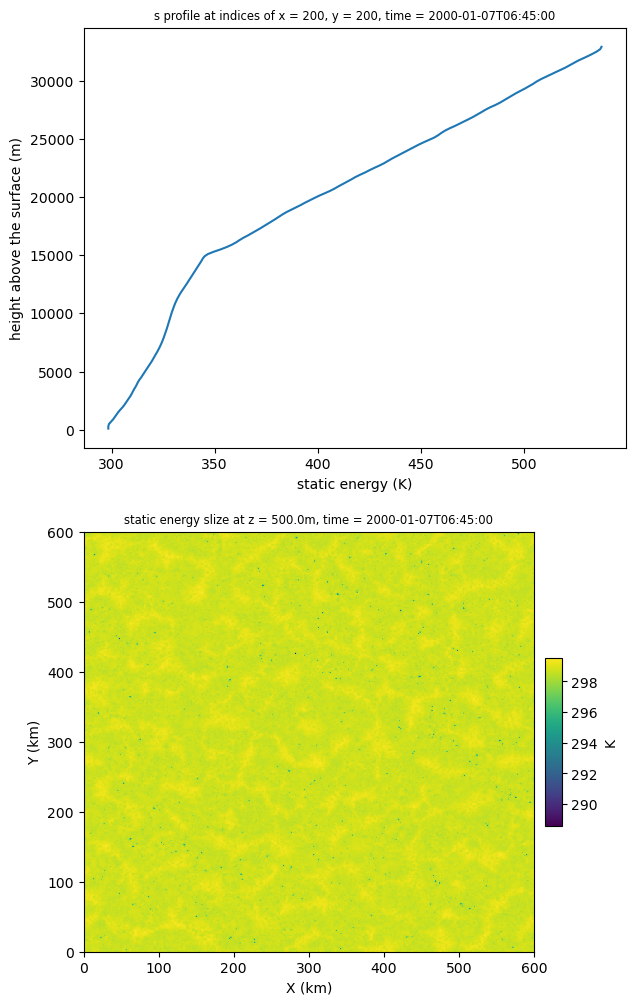

In [11]:
fig = plt.figure(figsize=(7,12))
ax = fig.add_subplot(2, 1, 1)

_=ax.plot(invar_proile,Z)
_=ax.set_xlabel(lname + ' (' + iunits + ')') #is the units for s correct?
_=ax.set_ylabel('height above the surface (m)')
_=ax.set_title((invarname + ' profile at indices of x = ' + str(ix) + ', y = ' 
               + str(iy) + ', time = ' + str(time[it])),fontsize = 'small')


ax = fig.add_subplot(2, 1, 2)
pcm=ax.pcolormesh(X/1000,Y/1000,invar_slice,shading='nearest')
_=ax.set_xlabel('X (km)') #is the units for s correct?
_=ax.set_ylabel('Y (km)')
_=ax.set_title((lname + ' slize at z = ' + str(Z[iz]) + 'm, time = ' + str(time[it])), 
               fontsize = 'small')
cbar = fig.colorbar(pcm,shrink = 0.4, pad=0.02, aspect=10,label = iunits, ax=ax)



### save snapshot (i.e., given time and height) of the selected variable in netcdf file



In [12]:
zlevel = 500 #m
iyear = 2000
imonth = 1
iday = 7
ihour_list = [6, 7 , 8, 9]
iminute_list = [0, 15, 30, 45]
isec = 0

nhour = len(ihour_list)
nminute = len(iminute_list)

In [ ]:
#index for the specified height level
iz  = find_closest_index(Z, zlevel)

In [106]:
#ihour = 7
#imin = 0
for ihour in ihour_list:
    for imin in iminute_list:
        itime = int2npdt64(iyear,imonth,iday, ihour, imin, isec, iunits = 'ns')
        it  = find_closest_index(time, itime)

        #create output variables as xr dataarray
        outvar = np.expand_dims(zin[igroup][it,varindx,:,:,iz], axis=0) #add back time dimension
        da_out = xr.DataArray(outvar, dims=["time","X","Y"])
        da_out.coords["X"] =X
        da_out.coords["Y"] =X
        da_out.coords["time"] = np.atleast_1d(itime) #for xarray's limitation to
        da_out.attrs["units"] = iunits
        da_out.attrs["long_name"] = lname

        # create output dataset
        ds_out = xr.Dataset()
        #coordinates
        ds_out.coords['X'] = ('X', X)
        ds_out.coords['Y'] = ('Y', Y)
        ds_out[invarname] = da_out

        #output file name and path
        outtime = (str(iyear).zfill(4) + "-" + str(imonth).zfill(2) + "-" + str(iday).zfill(2) + 
                  "_" + str(ihour).zfill(2) + str(imin).zfill(2) )
        outdir = '/pscratch/sd/k/ksa/temp'
        outfile = ('test_' + invarname + "_" + str(zlevel) + "m_" + outtime + ".nc")
        print("writing " + outdir + "/" + outfile)
        #write out
        ds_out.to_netcdf(path = (outdir + '/' + outfile), mode='w',format = 'NETCDF4',unlimited_dims='time')

        del da_out
        ds_out.close()
        del ds_out

writing /pscratch/sd/k/ksa/temp/test_s_500m_2000-01-07_0600.nc
writing /pscratch/sd/k/ksa/temp/test_s_500m_2000-01-07_0615.nc
writing /pscratch/sd/k/ksa/temp/test_s_500m_2000-01-07_0630.nc
writing /pscratch/sd/k/ksa/temp/test_s_500m_2000-01-07_0645.nc
writing /pscratch/sd/k/ksa/temp/test_s_500m_2000-01-07_0700.nc
writing /pscratch/sd/k/ksa/temp/test_s_500m_2000-01-07_0715.nc
writing /pscratch/sd/k/ksa/temp/test_s_500m_2000-01-07_0730.nc
writing /pscratch/sd/k/ksa/temp/test_s_500m_2000-01-07_0745.nc
writing /pscratch/sd/k/ksa/temp/test_s_500m_2000-01-07_0800.nc
writing /pscratch/sd/k/ksa/temp/test_s_500m_2000-01-07_0815.nc
writing /pscratch/sd/k/ksa/temp/test_s_500m_2000-01-07_0830.nc
writing /pscratch/sd/k/ksa/temp/test_s_500m_2000-01-07_0845.nc
writing /pscratch/sd/k/ksa/temp/test_s_500m_2000-01-07_0900.nc
writing /pscratch/sd/k/ksa/temp/test_s_500m_2000-01-07_0915.nc
writing /pscratch/sd/k/ksa/temp/test_s_500m_2000-01-07_0930.nc
writing /pscratch/sd/k/ksa/temp/test_s_500m_2000-01-07_

In [ ]:
# zin["restart_info"]['MicroBase']['RAINNC'].info


# zin["restart_info"]['TimeSteppingController'].info


# zin["restart_info"]['TimeSteppingController']['_time'].info


# zin["restart_info"]['TimeSteppingController']['_dt'].info


# zin["restart_info"]['MicroBase'].info


# zin["restart_info"]['MicroBase']['_itimestep'].info
